# Applying the Angiuli-Fouque-Lauriere Unified Two Timescale Mean Field Q-Learning Algorithm for Asymptotic Problems
## By: James Chen
## Adapted from: Farez Siddiqui

<br>
This mini-project was my attempt to learn more about mean field game (MFG)/mean field control (MFC) problems, and to attempt to engage with a new numerical method utilizing machine learning to solve such problems that was recently proposed by Andrea Angiuli, Jean-Pierre Fouque, and Mathieu Lauriere in their 2021 paper:

__[Unified Reinforcement Q-Learning for Mean Field Game and Control Problems](https://arxiv.org/abs/2006.13912)__

### MFG vs. MFC Formulations

MFG/MFC problems are similar in the sense that the solutions to these problems both involve:

**1) Finding the optimal control for a player/set of players
<br>2) Finding the stationary distribution associated with that optimal control**

The _difference_ between them lies in the order in which (1) and (2) are solved for. In MFG formulations, the players are thought to be _competing_ with each other, which implies each player is attempting to minimize their objective cost function alone and does not have access to knowledge of the distribution of players as governed by the environment's laws. This implies that iterative numerical procedures used to solve MFG problems should (in order): 

 **1) Freeze the distribution
<br> 2) Solve for the optimal control
<br> 3) Update the distribution
<br> 4) Repeat steps (1)-(3) until the stationary distribution is found (the Nash equilibrium)**

On the other hand, in MFC formulations the players are thought to be _cooperating_ with each other, meaning they share information with each other, which translates to the distribution of players being known to all players at all times. In terms of how the iterative numerical procedure is affected, it means the distribution is no longer frozen while the optimal control is solved for, but rather it is updated at the same time as the approximation of the optimal control is updated.

The _analytical_ solutions to these problems involve using a Hamiltonian-Jacobi-Bellman equation to solve for the optimal control, and using the Kolmogorov equation to solve for the stationary distribution for that control. In contrast, a _numerical_ solution to an MFG problem would involve writing an iterative procedure where the distribution is updated in an outer loop, and finding the optimal control is done in an inner loop (first an optimal control for a given distribution is found, then the distribution is updated). Whereas for an MFC problem the optimal control is found in the outer loop and the distribution is updated in an inner loop.

### Using Reinforcement Learning and Stochastic Approximation Concepts for a Generalized Numerical Approach

In Angiuli et al.'s paper, they propose a generalized algorithm for solving **both** MFG and MFC problems by replacing the presence of inner and outer loops with _different learning rates_ for updating the optimal control and distribution.

The approach borrows from Vivek Borkar's 1997 paper: __[Stochastic approximation with two time scales](https://www.sciencedirect.com/science/article/pii/S0167691197900153)__

_"[...] The motivation for studying this set-up comes from the following considerations. Suppose that an iterative algorithm calls for a particular sub-routine in each iteration. Suppose also that this subroutine itself is another iterative algorthm. The traditional method would be to use the output of the subroutine after running it 'long enough' (i.e., until near-convergence) during each iterate of the outer loop. But the foregoing suggests that we could get the same effect by running both the inner and the outer loops (i.e., the corresponding iterations) concurrently, albeit on different timescales. The inner 'fast' loop sees the outer 'slow' loop as quasi-static while the latter sees the former as nearly equilibrated."_
<br>- Vivek Borkar, [Stochastic Approximation - A Dynamical Systems Viewpoint](https://link.springer.com/book/10.1007/978-93-86279-38-5): Chapter 6 (2008)

Angiuli et al. proposed setting a learning rate for updating the distribution $\rho^\mu$ and a separate learning rate for updating the control $\rho^Q$ (it actually updates the Q-table, which determines the control, but more on that later) with the idea being that when $\rho^\mu<\rho^Q$ the distribution will update slower than the control (borrowing Borkar's language, the distribution will appear quasi-static to the control and the control will appear nearly equilibriated to the distribution) which means that it will solve the MFG formulation. Whereas if $\rho^\mu>\rho^Q$ the control will update slower than the distribution, which means that it will solve the MFC formulation.

#### A Quick Aside: A Brief Summary of Q-Learning

##### NOTE: The following 2 screenshots in this section are taken from Richard Sutton and Andrew Barto's book [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html)

Reinforcement Learning is a branch of machine learning concerned with learning an optimal policy for a certain environment. In simplistic terms, an agent will interact with an environment, receive feedback, update its idea of the laws governing the environment, and updates its policy until it believes it has a sufficient understanding of the environment and thus arrive at the optimal policy for interacting in that environment. For discrete/tabular problems, a state space is established that represents all the different states the agent may find itself in given the environment, and an action space that represents all the different actions the agent can take in each state. If the agent performs a particular action in a particular state, a reward (or cost depending on the problem) is received and the agent may find itself in a new state (the agent may also remain in the same state after taking an action), both being governed by the probabilistic laws the environment (which are unknown to the agent). So if there are $n$ states in the state space, and $m$ actions that can be taken in each state, a state-action value table is constructed whose dimensions are $nxm$ that represents the approximated "value" of taking an action in a certain state, which we refer to as a **Q-table**. How these Q-tables are updated depends on the type of Reinforcement Learning algorithm employed; I will briefly summarize one such algorithm below.

Q-Learning is a type of Reinforcement Learning that approximates the state-action value for a state-action pair by incrementing the value assuming the current approximation of the optimal action is taken in the following state:

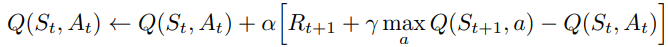

Where: 
<br>$S_{t}$ = The current state
<br>$A_{t}$ = The action taken in the current state
<br>$Q(S_{t},A_{t})$ = The current state-action value (Q-value) associated with the current state-action pair
<br>$\alpha$ = The step-size/learning rate
<br>$R_{t+1}$ = The reward received (or cost incurred) from taking the action in the current state
<br>$\gamma$ = The discount rate (the weight placed on future rewards/costs)
<br>$\underset{a}{\max}Q(S_{t+1},a)$ = The current Q-value associated with taking the currently approximated optimal action in the next state

One of the difficulties in constructing these types of algorithms is visiting other sub-optimal state-action pairs enough such that the agent can sufficiently approximate their Q-values. If the rule for action selection is to simply take the currently approximated optimal action every single time, sub-optimal state-action pairs will not be visited enough to sufficiently approximate their Q-values, which will challenge the optimality of the so-called "optimal policy" arrived at by this action selection rule. On the other hand, choosing an action _at random_ every single time can avoid this, but will significantly slow down convergence to a solution, and in the case of MFG/MFC problems will hinder the ability to find the stationary distribution associated with taking the optimal control.

The canonical and arguably most simple way to address this is to establish a parameter $\epsilon$ as an "exploration rate". Meaning, at each state, the agent will select the optimal action with probability $1-\epsilon$ and will select an action at random with probability $\epsilon$. This will allow sufficient exploration of sub-optimal policies over enough episodes for better approximation of the Q-table and thus more confidence in the optimality of the optimal policy. This action selection rule is known as the "$\epsilon$-greedy" rule.

Pseudocode for Q-Learning can be described as such:

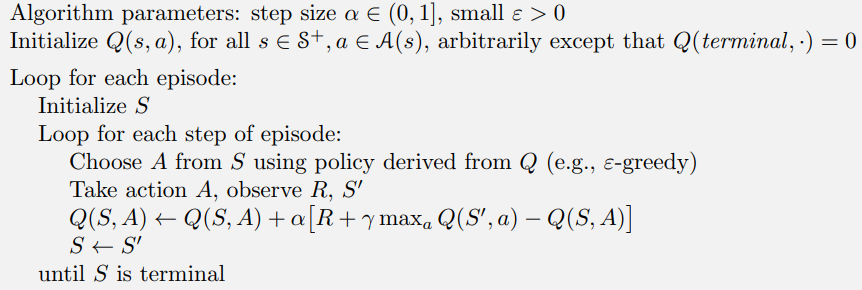

#### Putting it all together

Using the Q-Learning paradigm as a numerical means to converge to the optimal control, and using their own distribution update rule, and selecting appropriate learning rates $\rho^Q$ and $\rho^\mu$ for both (respectively), Angiuli et al. derived the following algorithm for solving MFG/MFC problems for an infinite time horizon:

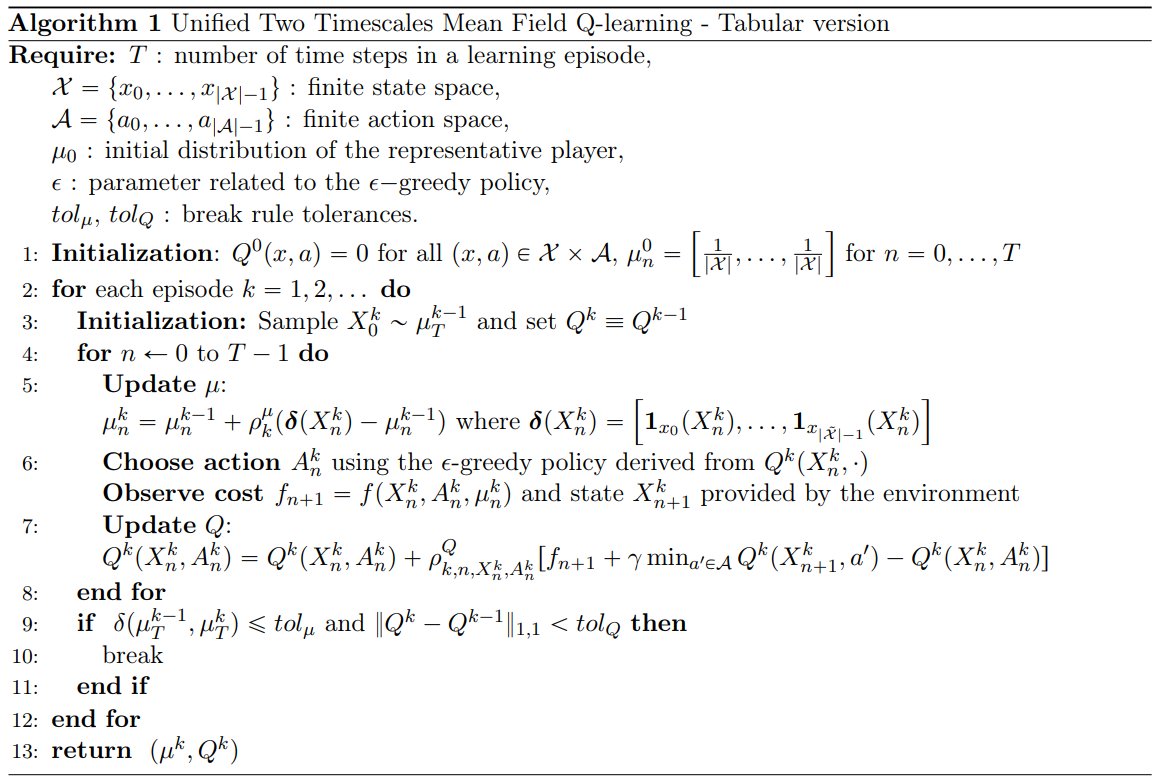

**NOTE: Since MFG/MFC problems are concerned with minimizing costs of agents rather than maximizing rewards as described in the Q-Learning summary above, the Q-Learning segment of the algorithm simply makes the action that *minimizes* the value as the optimal action, hence the presence of the $\min$ function rather than the $\max$ function.**

The learning rates are calculated as follows:

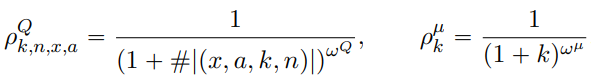

Where:
<br>$\#|(x,a,k,n)|$ = Number of times action $a$ was taken in state $x$ until episode $k$ and time $t_n$

$\omega^{Q}$ can take values in $(0.5,1)$, and $\omega^{\mu}$ is selected depending on the value of $\omega^{Q}$. The user will hand-select the values of these exponents by trial-and-error to satisfy either the MFG condition of $\rho^\mu<\rho^Q$ or the MFC condition of $\rho^\mu>\rho^Q$

### The Botnet Defense Problem

A "simple" first problem to test this algorithm on is one proposed by Vassili Kolokoltsov and Alain Bensoussan in their 2015 paper: __[Mean-field-game model for Botnet defense in Cyber-security](https://arxiv.org/abs/1511.06642)__

The paper models the interaction between a network of computers and a malicious attacker who is trying to infect them as an MFG problem. The vast number of computers that are in a network makes it amenable to being treated as a mean field, and the random propagation of infection, the various states the computers can be in, and decisions that the computers can make given their state and the costs being incurred also make it suitable for stochastic optimal control theory. Its "simplicity" comes from the fact that the state space and action space are both discrete and finite. 

In this problem, a network of computers is considered where each computer can be in one of four states at any given time:
<br>**Defended and Infected (DI)
<br>Defended and Susceptible (DS)
<br>Unprotected and Infected (UI)
<br>Unprotected and Susceptible (US)**

The cost incurred for being defended $k_D$ and the cost of being infected is $k_I$ (both for one unit of time)

The network of computers is under constant threat of infection by a malicious attacker (their constant threat is in fact quantified in this problem by the parameter $v_H$ as the rate of "direct effort", a quantification of how hard the attacker is trying). A computer in the network's susceptibility to direct infection by the attacker is quantified by the rate $q_{inf}^{D}$ if the computer is Defended, and $q_{inf}^{U}$ if the computer is Unprotected. These rates together make up a computer's rate of infection as a result of direct attack (depending on its state):

**$v_{H}q_{inf}^{D}$: The rate of infection by direct attack if the computer is Defended
<br>$v_{H}q_{inf}^{U}$: The rate of infection by direct attack if the computer is Unprotected**

Once a computer is infected, it can infect other computers at 2 of 4 rates depending on its own state and the state of the computers it is infecting:

**$\beta_{UU}$: The rate of infection from Unprotected computers to other Unprotected computers
<br>$\beta_{UD}$: The rate of infection from Unprotected computers to Defended computers
<br>$\beta_{DU}$: The rate of infection from Defended computers to Unprotected computers
<br>$\beta_{DD}$: The rate of infection from Defended computers to other Defended computers**

While the computer is infected, it will recover at rate $q_{rec}^{D}$ if it is Defended or $q_{rec}^{U}$ if is Unprotected.

Every computer has a binary decision to make at every point in time: _"Do I switch my defense level?"_

This action can be represented by a 1 if the computer is actively trying to change from Unprotected to Defended or Defended to Unprotected, and 0 if the computer is opting to stay either Unprotected or Defended. The speed at which the computer is able to change its defense level is given by the rate $\lambda$.

Finally we use $\mu(x)$ as the empirical distribution of states of the computers (i.e. $\mu(DI) = 0.25$ means 25% of computers in the network are Defended and Infected)

With all these parameters established, the instantaneous transition rate matrix for the state of a computer is given by the following if the action is 0 (the computer is opting stay at its current defense level):

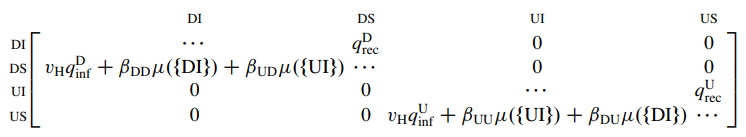

And the following if the action is 1 (the computer is actively trying to change its defense level):

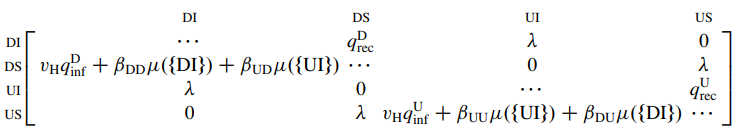

Where the "$...$" in each row represents the negative of the sum of the entries of that row.

**NOTE: The two matrices above were taken from René Carmona and François Delarue's textbook [Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6)**

In order to convert this instantaneous rate matrix to a transition probability matrix, its corresponding matrix exponential must be found by multiplying it by the time-step length identified by the numerical procedure and then using something like the Padé method to find the matrix exponential.

One final note is that when the malicious attacker is also treated as an active agent that is also trying to minimize its cost function, the problem setup is akin to an MFG, however in this setup the attacker is not considered to be an agent, and its direct effort is exogenized into the environment. The computer network alone is where the decision process is taking place, hence there is no "competition" to speak of so it will be treated as an MFC problem. This means that the exponents in the learning rates will be selected such that $\rho^\mu>\rho^Q$

René Carmona and François Delarue solve this problem analytically in Chapter 7 Section 2.3 of the first volume of their 2 volume textbook __[Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6)__ using the HJB and Kolmogorov equations stated previously (the values they used for the parameters described above can be found at the top of the code section below). I will be attempting to use Angiuli et al.'s algorithm to approximate the state distribution flow that they obtained for 3 different initial state distributions:

1) $\mu_{0}(DI) = \mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0.25$

2) $\mu_{0}(DI) = 1$, $\mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0$

3) $\mu_{0}(DI) = \mu_{0}(DS) = \mu_{0}(UI) = 0$, $\mu_{0}(US) = 1$

Each analytical solution to the state distribution flow provided by Carmona and Delarue will be shown after presenting the result of Angiuli et al.'s algorithm.

### Note on code

The following code was written solely by me, however I had to consult with [Jimin Li](https://www.linkedin.com/in/jm-lin/), a graduate student at the University of California - Santa Barbara to see where I was going wrong with my first draft by viewing his code (he and a team of other PhD students did this project together in the past, their impressive presentation on this problem can be found in the github repository [here](https://github.com/alexbstl/meanfield-cybersecurity)). In referencing their code, I made the following changes:

- I used the hyperparamaters for the RL algorithm ($\gamma$, the time discretization, and the learning rates) that Jimin and co. had used.

- Finding the matrix exponential of the transition rate matrix to obtain the probability matrix in order to determine the next state. I was originally doing a very convoluted "time tracking" method using the rates that was not true to the probabilistic nature of the problem. I had to review some literature on Markov Chains to understand why, a brief yet helpful explanation I found is in Section 2.1.1 of Chapter 12 of the book [Algebraic and Discrete Mathematical Methods for Modern Biology](https://www.sciencedirect.com/science/article/pii/B9780128012130000125).

- Using the cost array f to indicate the cost of being in each state for 1 unit of time, and simply accessing that cost by index and multiplying by the time-step to obtain the cost. I was originally using an overly complicated method of doing a boolean test on the state that acted as an indicator function, which would then be multiplied by the cost associated with that state. I'm still not sure where I went wrong with my logic, but the simplicity of Jimin and co's approach was appealing enough for me to use instead.

- I initially was using a different algorithm by Angiuli et al. from their 2021 paper [Reinforcement Learning for Mean Field Games, with Applications to Economics](https://arxiv.org/abs/2106.13755) which deals with situations where the time horizon is finite. I initially thought this was the algorithm I would need to use since Carmona and Delarue terminate analysis of the problem at T = 10, however the botnet defense problem is actually an asymptotic one that has an infinite time horizon, and Carmona and Delarue only show the solution up to T = 10 because that is where they saw convergence to the stationary distribution. After I realized my mistake, I made the necessary changes. The finite time horizon algorithm differs from the asymptotic algorithm by a few things:

>1) Instead of updating a state distribution, a the finite time horizon algorithm updates the state-action distribution. So the distribution update does not occur until after the action is selected

>2) Both the Q-table and state-action visit counter used to calculate $\rho^Q$ have an extra dimension added to them in the finite horizon algorithm, which is the dimension of time. In the finite time formulation, the Q-value of state-action pairs is treated as time-dependent. This is obviously not the case in the botnet security problem.

My initial draft of my code before I made the above changes can be found on my github [here](https://github.umn.edu/siddi030/AFL-RL-Algo---Botnet-MFG/blob/master/botnet_MFG.py).

In [ ]:
# spread of infection rates between computers
beta_UU = .3
beta_UD = .4
beta_DU = .3
beta_DD = .4

# recovery and infection rates
q_rec_D = .5
q_rec_U = .4
q_inf_D = .4
q_inf_U = .3

# cost rates
k_D = .3
k_I = .5

# rate of direct effort by herder
v_H = .6

# speed of response rate for taking action to change state
lambd = .8

# states:
# index 0: DI
# index 1: DS
# index 2: UI
# index 3: US

# cost array (each element corresponds with each state's incurred cost for 1 unit of time)
f = np.array([k_D + k_I, k_D, k_I, 0])

In [3]:
def Q_matrix(action, mu):
    '''
    Transition rate matrix for a given action and state distribution
    As described in the Botnet defense problem by Kolokoltsov & Bensoussan
    '''
    Q_matrix = np.empty((4,4))
    
    if action == 0:
        Q_matrix[0] = np.array([-q_rec_D, q_rec_D, 0, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2], 0, 0])
        Q_matrix[2] = np.array([0, 0, -q_rec_U, q_rec_U])
        Q_matrix[3] = np.array([0, 0, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0]])
    elif action == 1:
        Q_matrix[0] = np.array([-q_rec_D - lambd, q_rec_D, lambd, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2] - lambd, 0, lambd])
        Q_matrix[2] = np.array([lambd, 0, -q_rec_U - lambd, q_rec_U])
        Q_matrix[3] = np.array([0, lambd, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0] - lambd])
    
    return Q_matrix
    
    
def RL(epsilon, gamma, omega_Q, omega_mu, mu_0, T, N_s, episodes):
    '''
    Angiuli-Fouque-Lauriere Unified Two Timescale Mean Field Q-Learning algorithm for asymptotic regimes
    Specifically written for the Botnet defense problem by Kolokoltsov & Bensoussan
    '''
    # initialize state distribution flow
    mu = np.zeros((episodes,N_s+1,4))
    mu[:,0] = mu_0
    
    # initialize Q table
    Q = np.zeros((4,2))
    
    # counter for each time state-action pair is visited for use in calculating learning rate for Q
    sa_counter = np.ones((4,2))
    
    # will be used for analysis of learning rates
    rho_Q_plot = np.zeros((episodes, N_s+1))
    rho_mu_plot = np.zeros(episodes)
    
    # time-step length
    delta_t = T/N_s
    
    # matrix that when sliced on state index will serve as dirac delta for that state for updating distribution
    dirac = np.diag([1,1,1,1])
    
    # loop through episodes
    for k in tqdm(range(episodes)):
        
        # calculate state distribution learning rate for episode
        rho_mu = 1/(1 + (k+1))**omega_mu
        rho_mu_plot[k] = rho_mu
        
        # randomly select starting state based on initial distribution
        X = rnd.choice(np.arange(4), p = mu_0)
        
        # simulate episode
        for tau in range(1,N_s+1):
            
            # update distribution
            if k == 0:
                mu[k, tau] = mu_0 + rho_mu*(dirac[X] - mu_0)
            else:
                mu[k, tau] = mu[k-1, tau] + rho_mu*(dirac[X] - mu[k-1, tau])
                
            # give optimal action for given Q table
            min_A = np.argmin(Q[X])
            
            # use epsilon-greedy criterion for action selection
            if rnd.uniform() > epsilon:
                A = min_A
            else:
                A = rnd.choice([0,1])
                
            # increment counter for state-action visits by 1 for calculating learning rate for Q
            sa_counter[X, A] += 1

            # observe next state by converting the rate matrix to a probability matrix by finding matrix exponential
            state_trans_prob = expm(Q_matrix(A, mu[k, tau]) * delta_t)[X]
            X_prime = rnd.choice(range(4), p=state_trans_prob)
            
            # calculate learning rate for Q
            rho_Q = 1/(1 + sa_counter[X, A])**omega_Q
            rho_Q_plot[k, tau] = rho_Q
            
            # update Q table
            Q[X, A] = Q[X, A] + rho_Q * (f[X_prime]*delta_t + gamma*np.min(Q[X_prime]) - Q[X, A])

            # set next state for following time-step
            X = X_prime

    # closes tqdm instances so progress bar does not print to a new line with each iteration upon running again
    while len(tqdm._instances) > 0:
        tqdm._instances.pop().close()
        
    return mu, Q, rho_mu_plot, rho_Q_plot


# Finite Horizon

In [8]:
T = 100
N_s = 1000
delta_t = T/N_s

# number of episodes
episodes = 10000

# initial distributions and Q-table
mu = np.zeros((episodes,N_s,4))
nu = np.zeros((episodes,N_s,4,2))
mu_0 = np.array([.25,.25,.25,.25])
nu_0 = np.zeros((4,2)) + .125
Q = np.zeros((episodes,N_s,4,2))

# counter for each time state-action pair is visited at time t_n for use in calculating learning rate for Q
sa_counter = np.zeros((4,2,N_s))

# exploration rate for e-greedy
epsilon = .1
gamma = .5
omega_Q = .55
assert omega_Q >.5
assert omega_Q <= 1
omega_nu = .85
tol_nu = .0005
tol_Q = .0005

# will be used for analysis of learning rates
rho_Q_plot = np.zeros((episodes, N_s))
rho_nu_plot = np.zeros((episodes, N_s))


# states:
# 0 = DI
# 1 = DS
# 2 = UI
# 3 = US
def transition_rate(state, action, mu):
    
    Q_matrix = np.empty((4,4))
    
    if action == 0:
        Q_matrix[0] = np.array([-q_rec_D, q_rec_D, 0, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2], 0, 0])
        Q_matrix[2] = np.array([0, 0, -q_rec_U, q_rec_U])
        Q_matrix[3] = np.array([0, 0, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0]])
    elif action == 1:
        Q_matrix[0] = np.array([-q_rec_D - lambd, q_rec_D, lambd, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2] - lambd, 0, lambd])
        Q_matrix[2] = np.array([lambd, 0, -q_rec_U - lambd, q_rec_U])
        Q_matrix[3] = np.array([0, lambd, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0] - lambd])
    
    return Q_matrix[state]


for k in tqdm(range(episodes)):
    for tau in range(N_s):
        if tau == 0:
            # choose a random state if is the first time step of the episode
            X = rnd.choice(np.arange(4), p = mu_0)
            state_trans = np.zeros(4)
            state_trans[X] = 1.
        if k == 0:
            # if it is the first episode, choose action at random and use initial state-action distribution
            A = rnd.choice([0,1])
            v = nu_0
        else:
            # give optimal action for given Q table
            min_A = np.argmin(Q[k-1, tau, X])
            # use epsilon-greedy criterion for action selection
            if rnd.rand() > epsilon:
                A = min_A
            else:
                A = rnd.choice([0,1])
            # set state action distribution for update
            v = nu[k-1, tau]
        # increment counter for state-action-t_n visits by 1 for calculating learning rate for Q
        sa_counter[X, A, tau] += 1
        
        # calculate learning rates. if the MFG condition (rho_Q > rho_nu) does not hold, exit and prompt user to change
        # rho_Q = 1/(1 + N_s * sa_counter[X, A, tau])**omega_Q
        rho_Q = 1/(1 + sa_counter[X, A, tau])**omega_Q
        rho_nu = 1/(1 + (k+1))**omega_nu
        if rho_Q < rho_nu:
            print('\nMFG condition does not hold, adjust omegas such that rho_Q > rho_nu:')
            print('rho_Q: ', rho_Q)
            print('rho_nu: ', rho_nu)
            while len(tqdm._instances) > 0:
                tqdm._instances.pop().close()
            exit()
        rho_Q_plot[k, tau] = rho_Q
        rho_nu_plot[k, tau] = rho_nu
        
        # update state-action distribution
        dirac = np.zeros((4,2))
        dirac[X, A] = 1
        nu[k, tau] = v + rho_nu * (dirac - v)
        # update state distribution
        mu[k, tau] = nu[k, tau].sum(axis=1)
        # cost
        f = delta_t * (bool(X < 2) * k_D + bool(X==0 | X==2) * k_I)
        
        state_trans += transition_rate(X, A, mu[k, tau]) * delta_t
        state_trans = np.where(state_trans < 0, 0, state_trans)
        # print('\ntau: {} X: {} A: {}'.format(tau, X, A))
        # print(state_trans)
        
        full_trans = np.count_nonzero(state_trans >= 1)
        if full_trans == 0:
            X_prime = X
            
        elif full_trans == 1:
            X_prime = np.argmax(state_trans)
            state_trans[X] = 0
            
            # if a new state is reached, we preserve infection/recovery/progress towards D/S switching
            if X == 0 and X_prime == 1:
                state_trans[3] = state_trans[2]
                state_trans[2] = 0
            elif X == 0 and X_prime == 2:
                state_trans[3] = state_trans[1]
                state_trans[1] = 0
            elif X == 1 and X_prime == 0:
                state_trans[2] = state_trans[3]
                state_trans[3] = 0
            elif X == 1 and X_prime == 3:
                state_trans[2] = state_trans[0]
                state_trans[0] = 0
            elif X == 2 and X_prime == 0:
                state_trans[1] = state_trans[3]
                state_trans[3] = 0
            elif X == 2 and X_prime == 3:
                state_trans[1] = state_trans[0]
                state_trans[0] = 0
            elif X == 3 and X_prime == 1:
                state_trans[0] = state_trans[2]
                state_trans[2] = 0
            elif X == 3 and X_prime == 2:
                state_trans[0] = state_trans[1]
                state_trans[1] = 0
            
            state_trans[X_prime] = 1.
            
        elif full_trans == 2:
            # if full transition is reached for both states (due to lack of granularity of timestep),
            # it means the agent has completed U/D switch and also has become either infected or susceptible
            # so set the next state according to that
            state_trans = np.zeros(4)
            if X == 0:
                state_trans[3] = 1.
                X_prime = 3
            elif X == 1:
                state_trans[2] = 1.
                X_prime = 2
            elif X == 2:
                state_trans[1] = 1.
                X_prime = 1
            elif X == 3:
                state_trans[0] = 1.
                X_prime = 0
                
        elif full_trans > 2:
            print('\nWhat should we do here?')
            print('tau: ', tau)
            print('X:', X)
            print('A:', A)
            print(state_trans)
            while len(tqdm._instances) > 0:
                tqdm._instances.pop().close()
            exit()
        else:
            print('\nstate transition vector is weird:')
            print(state_trans)
            while len(tqdm._instances) > 0:
                tqdm._instances.pop().close()
            exit()
        
        # update Q
        if k == 0:
            q = np.zeros((4,2))
            q_prime = 0
        else:
            q = Q[k-1, tau]
            if tau < N_s - 1:
                q_prime = np.min(Q[k-1, tau+1, X_prime])
            else:
                q_prime = 0
        B = f + gamma * q_prime
        Q[k, tau] = q
        Q[k, tau, X, A] = q[X, A] + rho_Q * (B - q[X, A])
        
        # set next state
        X = X_prime
    
    # after episode has finished, check for convergence, else continue
    if k > 0:
        if abs(nu[k, tau] - nu[k-1, tau]).sum() <= tol_nu and abs(Q[k, tau] - Q[k-1, tau]).sum() <= tol_Q:
            print('\nSuccess: Algorithm has converged after ', k+1, ' episodes.')
            print('Final average state distribution: ', np.mean(mu[k,:,:], axis=0))

            while len(tqdm._instances) > 0:
                tqdm._instances.pop().close()
            exit()
        elif k == episodes - 1:
            print('\nFailure: Algorithm failed to converge. Adjust parameters or increase number of episodes.')

# plot the average state distributions for each episodes
plt.figure(0)
plt.plot(np.mean(mu[:k+1,:,:], axis=1))
plt.title('Average state distribution mu for each episode\nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('mu')
plt.legend(['DI','DS','UI','US'])
plt.show()

plt.figure(1)
plt.plot(np.mean(Q[:k+1,:,0,:], axis=1))
plt.title('Average Q values for state DI \nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('Q value')
plt.legend(['Action: 0','Action: 1'])
plt.show()

plt.figure(2)
plt.plot(np.mean(Q[:k+1,:,1,:], axis=1))
plt.title('Average Q values for state DS \nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('Q value')
plt.legend(['Action: 0','Action: 1'])
plt.show()

plt.figure(3)
plt.plot(np.mean(Q[:k+1,:,2,:], axis=1))
plt.title('Average Q values for state UI \nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('Q value')
plt.legend(['Action: 0','Action: 1'])
plt.show()

plt.figure(4)
plt.plot(np.mean(Q[:k+1,:,3,:], axis=1))
plt.title('Average Q values for state US \nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('Q value')
plt.legend(['Action: 0','Action: 1'])
plt.show()

plt.figure(5)
plt.plot(np.mean(rho_nu_plot[:k+1], axis=1))
plt.plot(np.mean(rho_Q_plot[:k+1], axis=1))
plt.title('Average Learning Rates\nepsilon = {}, gamma = {}\nT = {}, N = {}'.format(epsilon, gamma, T, N_s))
plt.xlabel('Episode')
plt.ylabel('Learning Rate')
plt.legend(['rho_nu','rho_Q'])
plt.show()

# plot the evolution of the state distribution in the final episode
# plt.plot(mu[k,:,:])
# plt.title('State distribution mu over final episode')
# plt.xlabel('Time')
# plt.ylabel('mu')
# plt.legend(['DI','DS','UI','US'])
# plt.show()

while len(tqdm._instances) > 0:
    tqdm._instances.pop().close()

NameError: name 'tqdm' is not defined

# First initial distribution: $\mu_{0}(DI) = \mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0.25$

In [4]:
# exploration rate for e-greedy
epsilon = .05 

# discount factor/weight on future costs
gamma = 1 

# controls learning rate for Q
omega_Q = .9 

# controls learning rate for state distribution
omega_mu = .6 

# initial state distribution for each episode
mu_0=[.25,.25,.25,.25]

# length of episode and discretization
T = 10
N_s = 100

# number of episodes
episodes = 30000

mu, Q, rho_mu, rho_Q = RL(epsilon, gamma, omega_Q, omega_mu, mu_0, T, N_s, episodes)


100%|██████████| 30000/30000 [1:14:26<00:00,  6.72it/s]     


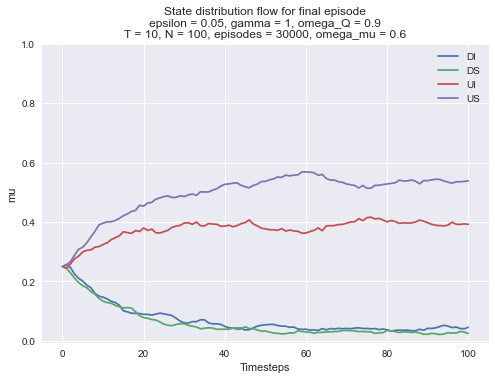

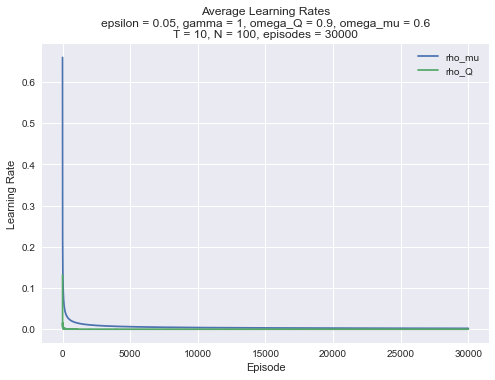

In [5]:
# plot the state distribution evolution for final episode
plt.figure(0)
plt.plot(mu[-1])
plt.title('State distribution flow for final episode\nepsilon = {}, gamma = {}, omega_Q = {}\nT = {}, N = {}, episodes = {}, omega_mu = {}'.format(epsilon, gamma, omega_Q, T, N_s, episodes, omega_mu))
plt.xlabel('Timesteps')
plt.ylabel('mu')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(['DI','DS','UI','US'])
plt.show()

# plot average learning rate for each episode
plt.figure(1)
plt.plot(rho_mu)
plt.plot(np.mean(rho_Q, axis=1))
plt.title('Average Learning Rates\nepsilon = {}, gamma = {}, omega_Q = {}, omega_mu = {}\nT = {}, N = {}, episodes = {}'.format(epsilon, gamma, omega_Q, omega_mu, T, N_s, episodes))
plt.xlabel('Episode')
plt.ylabel('Learning Rate')
plt.legend(['rho_mu','rho_Q'])
plt.show()

### Compared to the analytical solution:

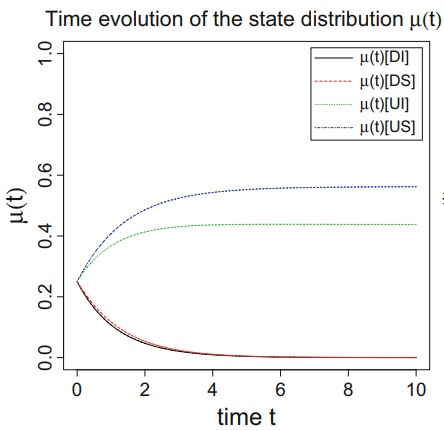

# Second initial distribution: $\mu_{0}(DI) = 1$, $\mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0$

In [6]:
# exploration rate for e-greedy
epsilon = .05 

# discount factor/weight on future costs
gamma = 1 

# controls learning rate for Q
omega_Q = .9 

# controls learning rate for state distribution
omega_mu = .6 

# initial state distribution for each episode
mu_0=[1,0,0,0]

# length of episode and discretization
T = 10
N_s = 100

# number of episodes
episodes = 30000

mu, Q, rho_mu, rho_Q = RL(epsilon, gamma, omega_Q, omega_mu, mu_0, T, N_s, episodes)


100%|██████████| 30000/30000 [11:22<00:00, 43.99it/s]


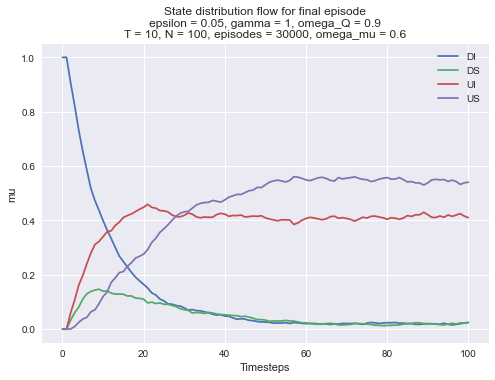

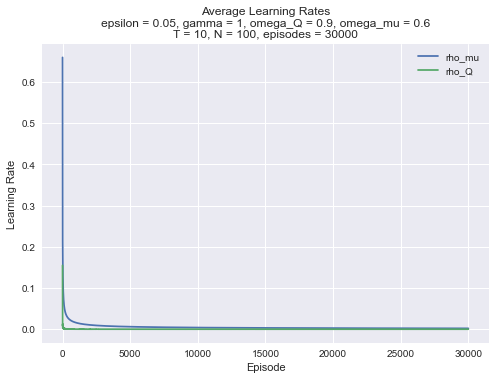

In [7]:
# plot the state distribution evolution for final episode
plt.figure(0)
plt.plot(mu[-1])
plt.title('State distribution flow for final episode\nepsilon = {}, gamma = {}, omega_Q = {}\nT = {}, N = {}, episodes = {}, omega_mu = {}'.format(epsilon, gamma, omega_Q, T, N_s, episodes, omega_mu))
plt.xlabel('Timesteps')
plt.ylabel('mu')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(['DI','DS','UI','US'])
plt.show()

# plot average learning rate for each episode
plt.figure(1)
plt.plot(rho_mu)
plt.plot(np.mean(rho_Q, axis=1))
plt.title('Average Learning Rates\nepsilon = {}, gamma = {}, omega_Q = {}, omega_mu = {}\nT = {}, N = {}, episodes = {}'.format(epsilon, gamma, omega_Q, omega_mu, T, N_s, episodes))
plt.xlabel('Episode')
plt.ylabel('Learning Rate')
plt.legend(['rho_mu','rho_Q'])
plt.show()

### Compared to the analytical solution:

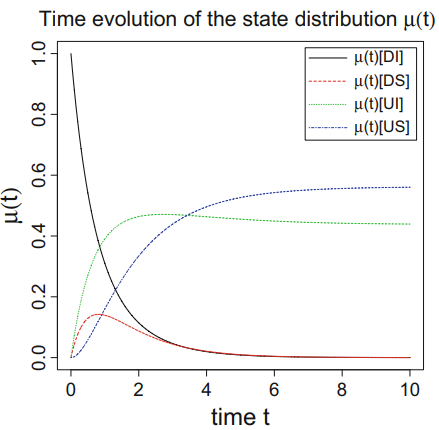

# Third initial distribution: $\mu_{0}(DI) = \mu(DS) = \mu_{0}(UI) = 0$, $\mu_{0}(US) = 1$

In [8]:
# exploration rate for e-greedy
epsilon = .05 

# discount factor/weight on future costs
gamma = 1

# controls learning rate for Q
omega_Q = .9

# controls learning rate for state distribution
omega_mu = .6

# initial state distribution for each episode
mu_0=[0,0,0,1]

# length of episode and discretization
T = 10
N_s = 100

# number of episodes
episodes = 30000

mu, Q, rho_mu, rho_Q = RL(epsilon, gamma, omega_Q, omega_mu, mu_0, T, N_s, episodes)


100%|██████████| 30000/30000 [11:57<00:00, 41.79it/s]


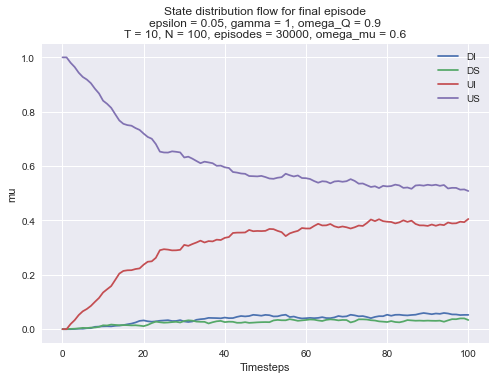

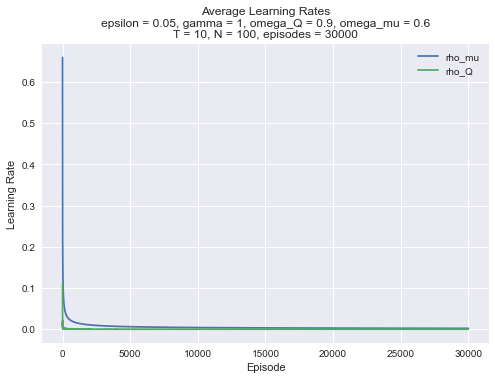

In [9]:
# plot the state distribution evolution for final episode
plt.figure(0)
plt.plot(mu[-1])
plt.title('State distribution flow for final episode\nepsilon = {}, gamma = {}, omega_Q = {}\nT = {}, N = {}, episodes = {}, omega_mu = {}'.format(epsilon, gamma, omega_Q, T, N_s, episodes, omega_mu))
plt.xlabel('Timesteps')
plt.ylabel('mu')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.legend(['DI','DS','UI','US'])
plt.show()

# plot average learning rate for each episode
plt.figure(1)
plt.plot(rho_mu)
plt.plot(np.mean(rho_Q, axis=1))
plt.title('Average Learning Rates\nepsilon = {}, gamma = {}, omega_Q = {}, omega_mu = {}\nT = {}, N = {}, episodes = {}'.format(epsilon, gamma, omega_Q, omega_mu, T, N_s, episodes))
plt.xlabel('Episode')
plt.ylabel('Learning Rate')
plt.legend(['rho_mu','rho_Q'])
plt.show()

### Compared to the analytical solution:

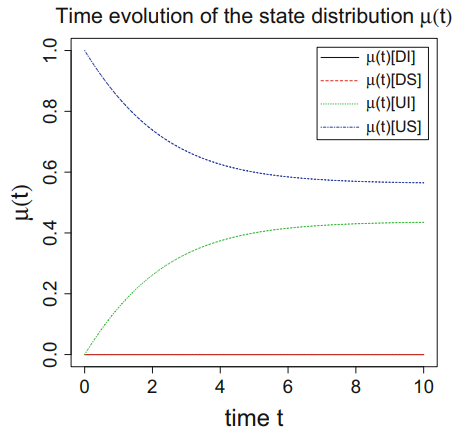

# References

1) [Unified Reinforcement Q-Learning for Mean Field Game and Control Problems](https://arxiv.org/abs/2006.13912) - Andrea Angiuli, Jean-Pierre Fouque, and Mathieu Lauriere (2021)

2) [Stochastic approximation with two time scales](https://www.sciencedirect.com/science/article/pii/S0167691197900153) - Vivek Borkar (1997)

3) [Stochastic Approximation - A Dynamical Systems Viewpoint](https://link.springer.com/book/10.1007/978-93-86279-38-5) - Vivek Borkar (2008)

4) [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) - Richard Sutton and Andrew Barto (2018)

5) [Mean-field-game model for Botnet defense in Cyber-security](https://arxiv.org/abs/1511.06642) - Vassili Kolokoltsov and Alain Bensoussan (2015)

6) [Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6) - René Carmona and François Delarue (2018)

7) [Algebraic and Discrete Mathematical Methods for Modern Biology](https://www.sciencedirect.com/science/article/pii/B9780128012130000125) - Grady Weyenberg and Ruriko Yoshida (2015)

8) [Reinforcement Learning for Mean Field Games, with Applications to Economics](https://arxiv.org/abs/2106.13755) - Andrea Angiuli, Jean-Pierre Fouque, and Mathieu Lauriere (2021)

9) [Jimin Li, Cosmin Borsa, and Alex Bernstein's code](https://github.com/alexbstl/meanfield-cybersecurity)

In [ ]:
# spread of infection rates between computers
beta_UU = .3
beta_UD = .4
beta_DU = .3
beta_DD = .4

# recovery and infection rates
q_rec_D = .5
q_rec_U = .4
q_inf_D = .4
q_inf_U = .3

# cost rates
k_D = .3
k_I = .5

# rate of direct effort by herder
v_H = .6

# speed of response rate for taking action to change state
lambd = .8

# states:
# index 0: DI
# index 1: DS
# index 2: UI
# index 3: US

# cost array (each element corresponds with each state's incurred cost for 1 unit of time)
f = np.array([k_D + k_I, k_D, k_I, 0])

# Following transition rate in trader execution problem related to volatility?

In [3]:
import math
import numpy as np
from numpy import random as rnd
from scipy.linalg import expm
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [4]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def update_X_prime(x, alpha):
    proposed = state_space[x] + action_space[alpha]*dt + sigma*rnd.randn()*np.sqrt(dt)
    X_prime = find_nearest(state_space, proposed)
    return X_prime

In [12]:
d = 4
m = 5
X = 1
A = 0

dirac = np.diag(np.ones((d*m)))
dirac[X*m+A].reshape(d,m)

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
#utilize previous Q table for efficiency
def RL(episodes):
    '''
    Angiuli-Fouque-Lauriere Unified Two Timescale Mean Field Q-Learning algorithm for asymptotic regimes
    Specifically written for the Botnet defense problem by Kolokoltsov & Bensoussan
    '''
    # cardinality of state & action spaces
    d = len(state_space)
    m = len(action_space)

    # initialize state distribution flow
    nu    = np.zeros((N_s, d, m))
    nu[0,:] = np.tile(mu_0, m).reshape(d,m)     # the same init dist mu_0 for all actions

            # (1/(d*m))*np.ones((N_s+1, d, m))    alternative where I'm assuming
                                                # uniform dist for all state-action pairs
    
    # initialize Q table
    Q = np.zeros((N_s+1, d, m)) # will be updated but not stored
    
    # counter for each time state-action pair is visited for use in calculating learning rate for Q
    sa_counter = np.ones((N_s, d, m))
    
    # will be used for analysis of learning rates
    #rho_Q_plot  = np.zeros((episodes, N_s+1))
    #rho_nu_plot = np.zeros(episodes)

    # matrix that when sliced on state index will serve as dirac delta for that state for updating distribution
    dirac = np.diag(np.ones((d*m)))
    
    # loop through episodes
    for k in tqdm(range(1,episodes)):
        
        # calculate state distribution learning rate for episode
        rho_nu = 1/(1 + (k+1))**omega_nu
        # rho_nu_plot[k] = rho_nu
        
        # randomly select starting state based on initial distribution
        X = rnd.choice(range(d), p = mu_0)
        
        # simulate episode
        for tau in range(N_s):
            
            # give optimal action for given Q table
            min_A = np.argmin(Q[tau, X])
            
            # use epsilon-greedy criterion for action selection
            if rnd.uniform() > epsilon:
                A = min_A
            else:
                A = rnd.choice(range(m))

            # update distribution
            nu[tau] = nu[tau] + rho_nu*(dirac[X*m+A].reshape(d,m) - nu[tau])
            
            # increment counter for state-action visits by 1 for calculating learning rate for Q
            sa_counter[tau, X, A] += 1

            # observe next state by converting the rate matrix to a probability matrix by finding matrix exponential
            # state_trans_prob = expm(transition_rate(A, nu[k, tau, :, A]) * delta_t)[X]
            X_prime = update_X_prime(X, A)
            
            # calculate learning rate for Q (notice the N_s for finite horizon)
            rho_Q = 1/(1 + N_s*sa_counter[tau, X, A])**omega_Q
            #rho_Q_plot[k, tau] = rho_Q
            
            # update Q table
            if tau == N_s:
                B = (c_g/2)*state_space[X_prime]**2 # Almgren-Chriss framework
            else:
                B = f(X_prime, A, nu[tau]) + gamma*np.min(Q[tau+1, X_prime])
            Q[tau, X, A] = Q[tau, X, A] + rho_Q*(B - Q[tau, X, A])

            # set next state for following time-step
            X = X_prime

    # closes tqdm instances so progress bar does not print to a new line with each iteration upon running again
    while len(tqdm._instances) > 0:
        tqdm._instances.pop().close()
        
    return nu, Q #, rho_nu_plot, rho_Q_plot

In [6]:
T        = 1
N_s      = 16

# time-step length
dt = T/N_s

# state space & action space
a            = -1.5 # min of state space
b            = 1.75 # max of state space
state_space  = np.arange(a, b, np.sqrt(1/N_s))
action_space = np.arange(-2.5, 1, np.sqrt(1/N_s))

# parameters
c_alpha  = 1
c_x      = 2
c_g      = .3

mu_0     = norm.pdf(state_space, .5, .3)*np.sqrt(1/N_s) # normal distribution probabilities
mu_0     += (1 - sum(mu_0))/len(state_space)            # an attempt at discretization

sigma    = .5

# exploration rate for e-greedy
epsilon  = .1

# discount factor/weight on future costs
gamma    = 1.75

# controls learning rate for Q
omega_Q  = .55

# controls learning rate for state distribution
omega_nu = .85

# cost
def f(x, alpha, nu):
    return ((c_alpha/2)*action_space[alpha]**2 + (c_x/2)*state_space[x]**2
            - gamma*state_space[x]*action_space@np.sum(nu, axis = 0))
                                # inner product for integral


# here goes nothing...

nu, Q = RL(100000)

100%|██████████| 99999/99999 [02:35<00:00, 644.10it/s] 


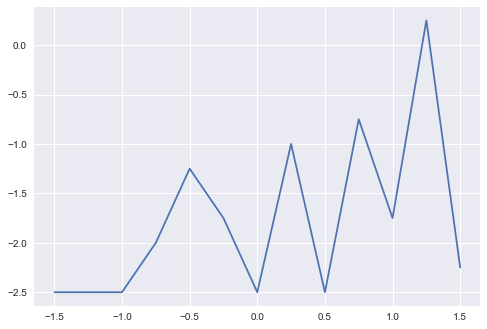

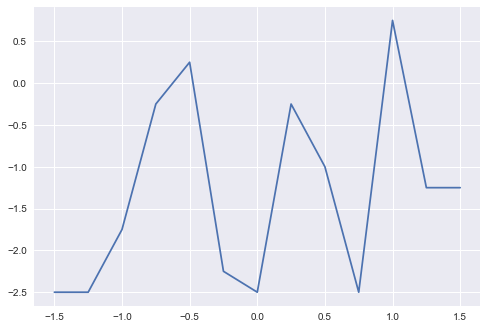

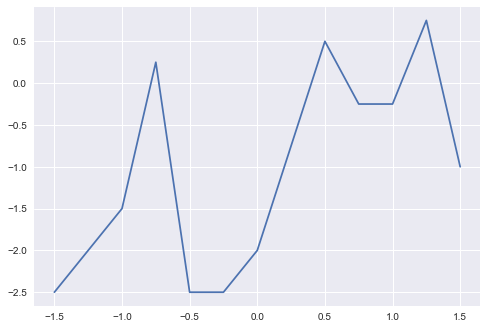

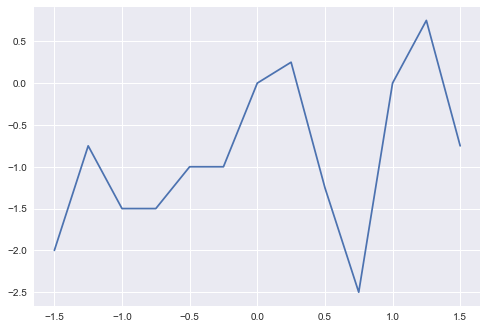

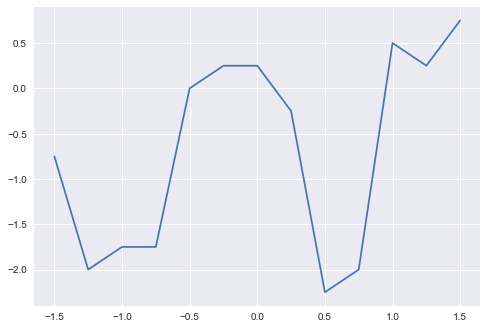

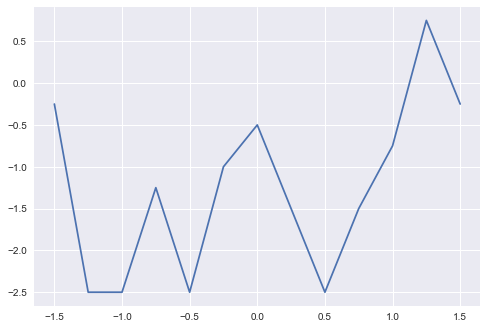

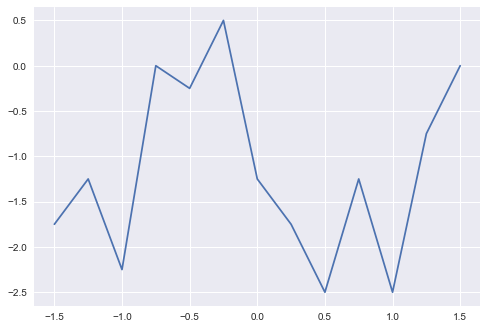

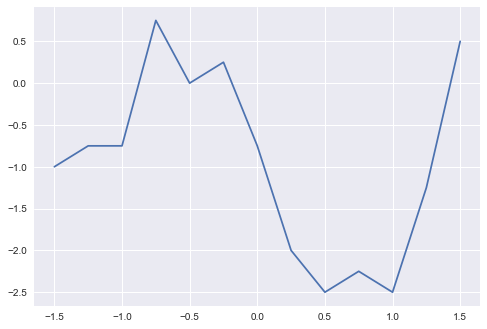

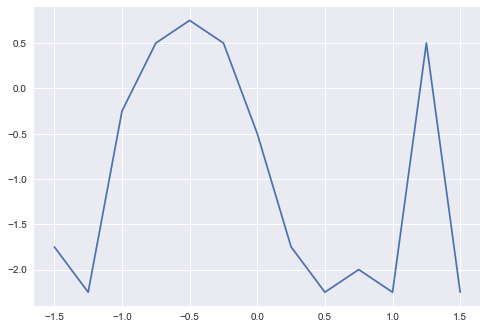

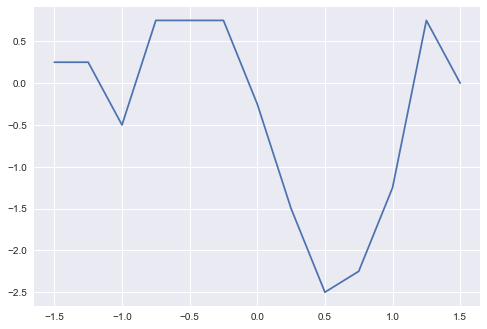

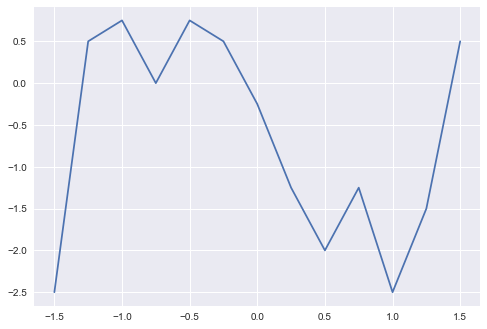

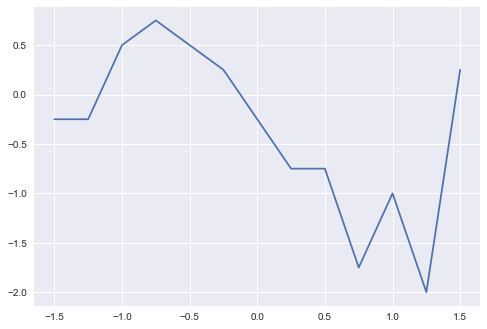

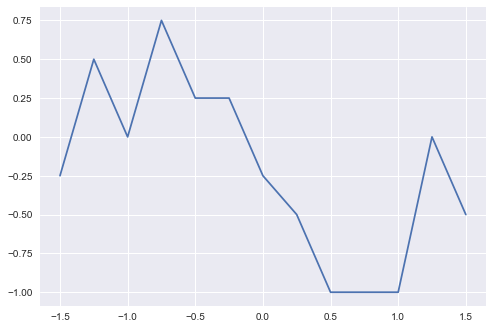

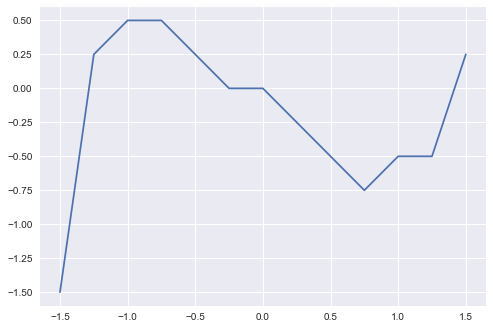

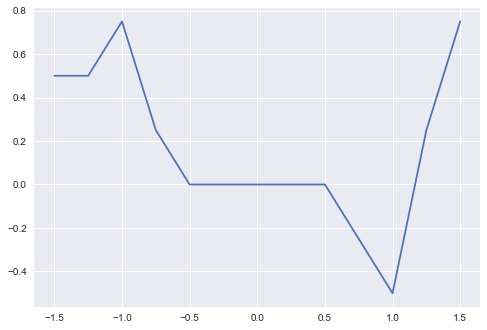

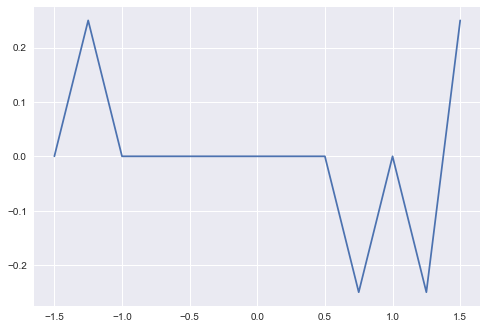

In [7]:
# plot the state distribution evolution for final episode

# plot average learning rate for each episode
for i in range(16):
    plt.figure(i)
    plt.plot(state_space, action_space[np.argmin(Q[i, :], axis = 1)])
plt.show()